In [15]:
import numpy as np
import scipy.sparse as sp
from umap import UMAP
from hdbscan import HDBSCAN
import matplotlib.pyplot as plt
import glasbey
from tqdm import tqdm
from fstar import fstar

import igraph as ig
import partition_igraph

from cove import COVE
from cove.dimension_reduction import LaplacianEigenmap, UMAPLE
from utils import *

In [26]:
adj, lab = load_graph("airport")
adj

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 31128 stored elements and shape (2898, 2898)>

In [27]:
window_size = 7
walk_len = 40
n_walks = 10
high = COVE(window_length=window_size, walks_per_node=n_walks, walk_length=walk_len).fit_transform(adj)
umaple = UMAPLE(dimension=2).fit_transform(high, adj)
n2v = node2vec(adj, 2, num_walks=n_walks, walk_length=walk_len, window_size=window_size)
high = node2vec(adj, 64, num_walks=n_walks, walk_length=walk_len, window_size=window_size)
umap = UMAP(metric="cosine").fit_transform(high)

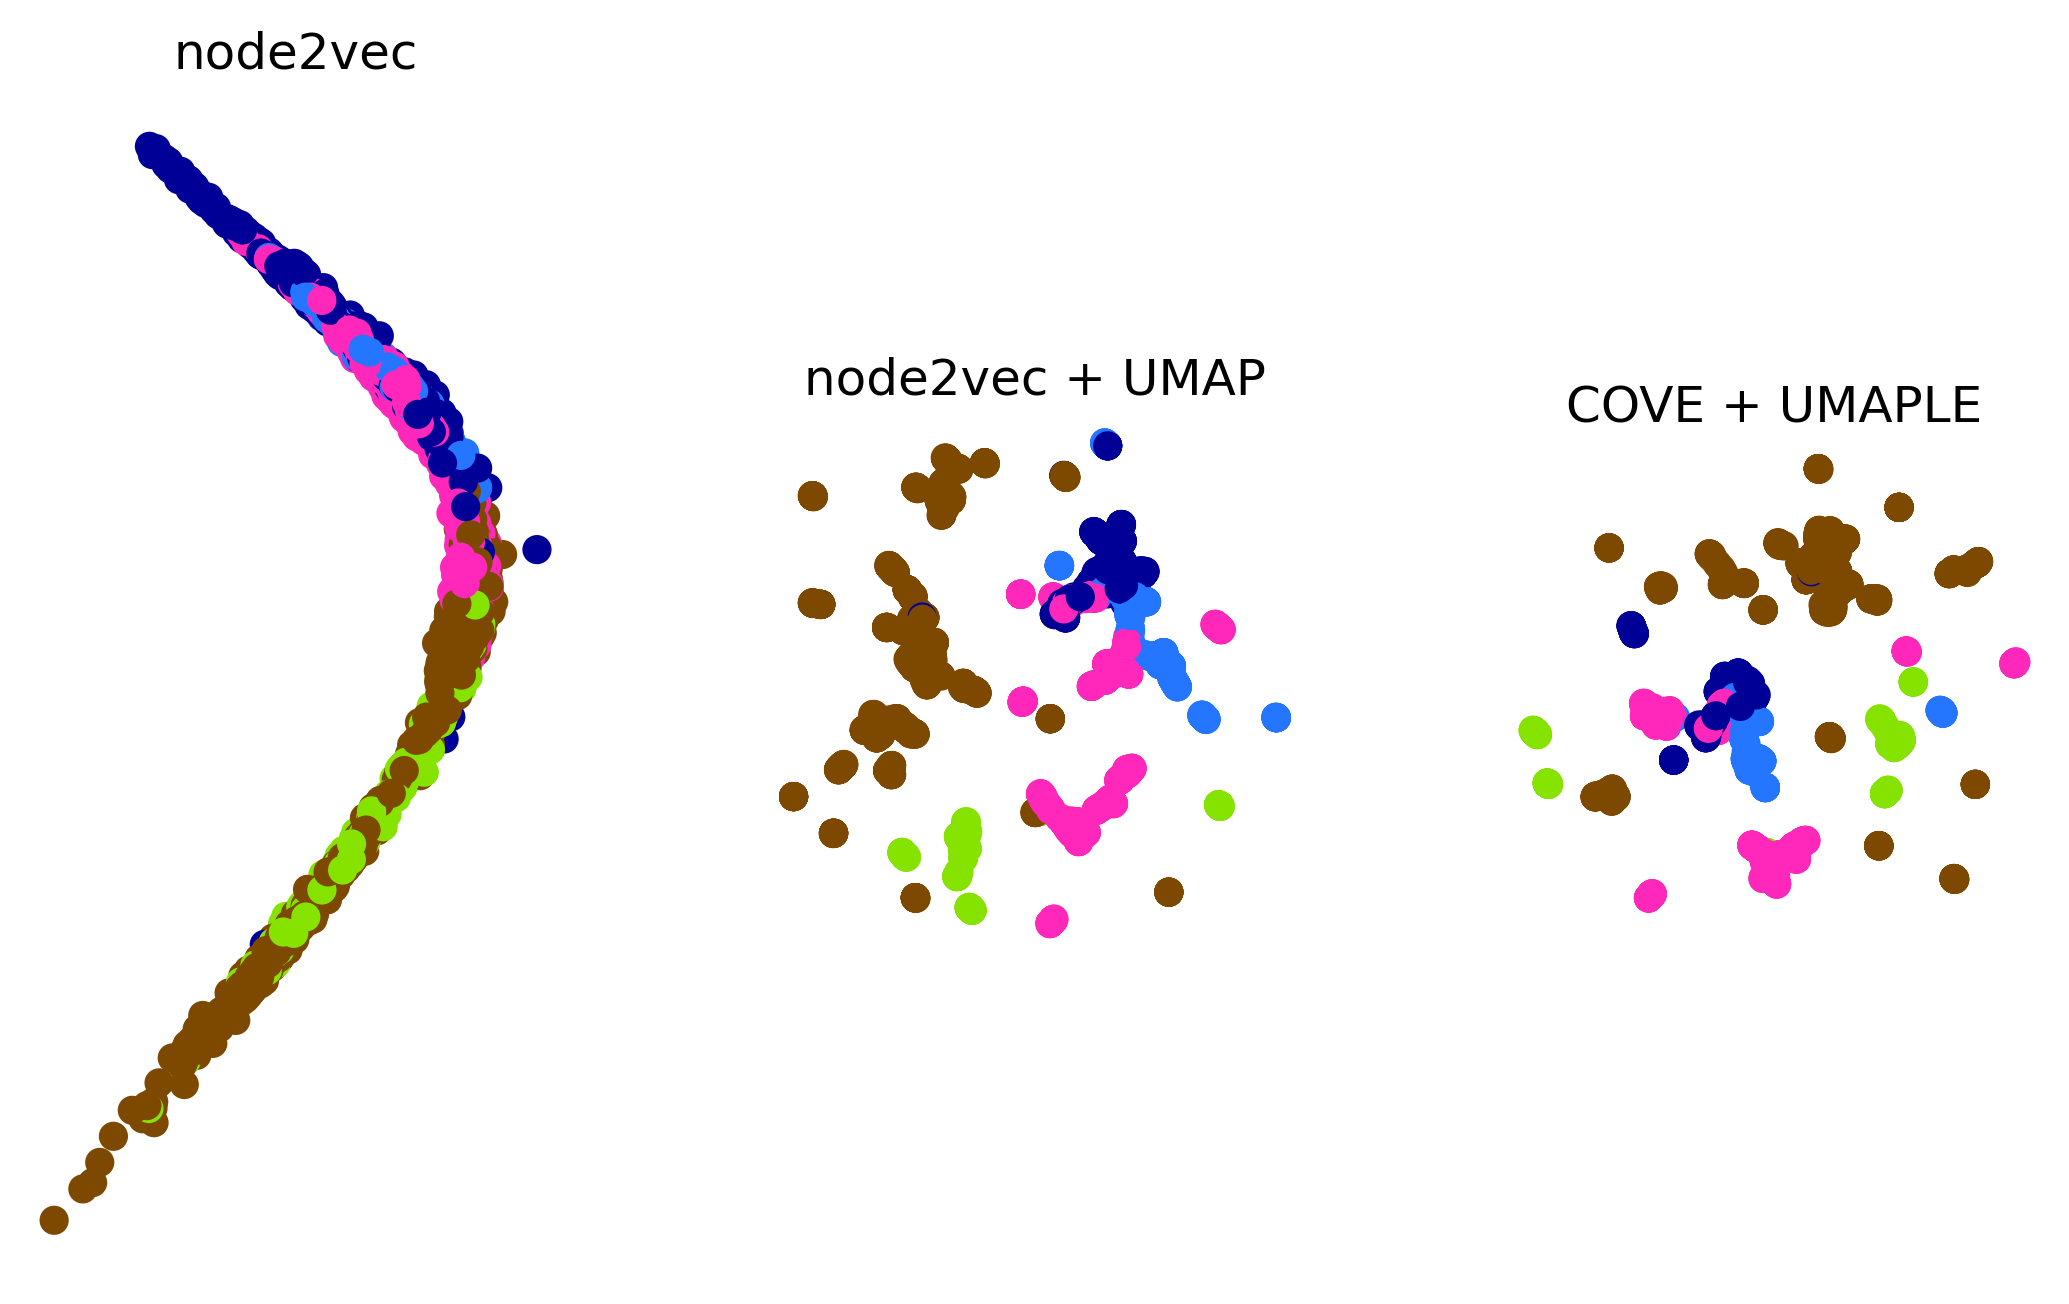

In [29]:
palette = glasbey.create_palette(palette_size=np.max(lab)+1, colorblind_safe=True, optimize_palette_search_radius=50)
colors = [palette[i] if i >= 0 else (0.7, 0.7, 0.7) for i in lab]

fig, axs = plt.subplots(1,3, figsize=(7,6), dpi=300)
axs[0].scatter(n2v[:, 0], n2v[:, 1], c=colors)
axs[1].scatter(umap[:, 0], umap[:, 1], c=colors)
axs[2].scatter(umaple[:, 0], umaple[:, 1], c=colors)

for ax in axs:
    ax.set_axis_off()
    ax.set_aspect("equal")

axs[0].set_title("node2vec")
axs[1].set_title("node2vec + UMAP")
axs[2].set_title("COVE + UMAPLE")

plt.tight_layout(w_pad=5)

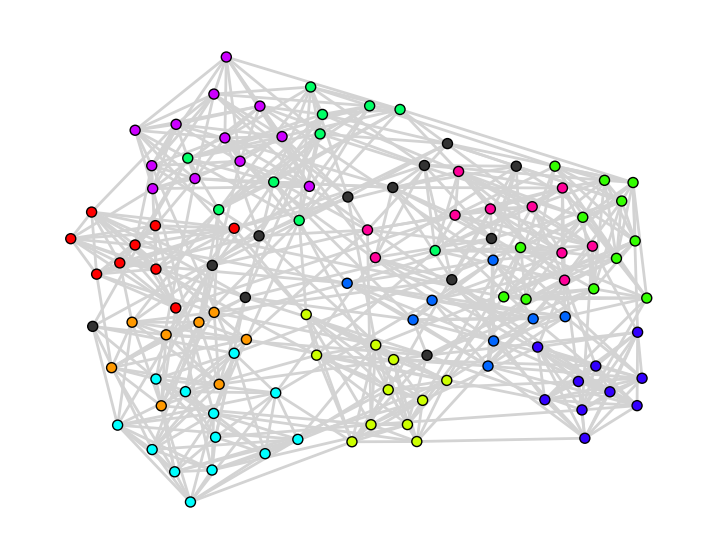

In [11]:
# force directed layout with edges and ecg
g = ig.Graph.Adjacency(adj.astype("int64"), mode="undirected")
g.vs["com"] = lab

g.vs['shape'] = 'circle'
pal = ig.RainbowPalette(n=max(g.vs['com'])+1) 
g.vs['color'] = [pal.get(int(i)) if i >= 0 else (0.2, 0.2, 0.2) for i in g.vs['com']]

ecg = g.community_ecg()
g.es['weight'] = ecg.W
ly = g.layout_fruchterman_reingold(weights='weight')

fig, ax = plt.subplots(figsize=(9,7))
ig.plot(g, layout=ly, vertex_size=10, edge_color='lightgray', target=ax)